In [1]:
import numpy as np
import nibabel
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
def get_pixel_arrays(root, folder):
    img = dict()

    img['BRAIN'] = nibabel.load(root / '5_ss_shared' / folder.name / 'FLAIR_mask.nii.gz').get_fdata() # BGPD
    for modality in ['CT1', 'FLAIR', 'T1', 'T2', 'mask_GTV_FLAIR']: # BGPD
#     img['BRAIN'] = nibabel.load(root / '5_ss_shared' / folder.name / 'CT1_mask.nii.gz').get_fdata() # GBM
#     for modality in ['CT1', 'FLAIR', 'T1', 'T2', 'CT1_SEG']: # GBM
        img[modality] = nibabel.load(folder / f'{modality}.nii.gz').get_fdata()

    img_healthy = dict()
    img_tumour = dict()
    for modality in ['CT1', 'FLAIR', 'T1', 'T2']:
        img_healthy[modality] = img[modality][img['BRAIN'].astype(bool)^img['mask_GTV_FLAIR'].astype(bool)]        
        img_healthy[modality] = (img_healthy[modality] - img_healthy[modality].mean()) / img_healthy[modality].std()

    return img_healthy

In [3]:
def compute_percentiles(x):
    return {
        5: np.percentile(x, 5),
        25: np.percentile(x, 25),
        50: np.percentile(x, 50),
        75: np.percentile(x, 75),
        95: np.percentile(x, 95)
    }

def save_percentiles(x, dst_folder, patient, modality):
    dst_root = dst_folder / patient
    if not dst_root.exists():
        dst_root.mkdir(parents=True)
    
    percentiles = compute_percentiles(x)
    with open(dst_root / f'{modality}.pkl', 'wb') as f:
        pickle.dump(percentiles, f)

# Save percentiles BGPD

In [4]:
root = Path('/anvar/public_datasets/preproc_study/bgpd/')

In [5]:
for folder in [
    root / '4a_resamp']:
    for patient in tqdm(folder.glob('*')):
        healthy = get_pixel_arrays(root, patient)
        for modality in ['CT1', 'FLAIR', 'T1', 'T2']:
            save_percentiles(
                healthy[modality],
                Path('/anvar/public_datasets/preproc_study/percentiles/bgpd/') / folder.name,
                patient.name,
                modality
            )

180it [07:48,  2.60s/it]


# Save percentiles GBM

In [6]:
def get_pixel_arrays(root, folder):
    img = dict()

#     img['BRAIN'] = nibabel.load(root / '5_ss_shared' / folder.name / 'FLAIR_mask.nii.gz').get_fdata() # BGPD
#     for modality in ['CT1', 'FLAIR', 'T1', 'T2', 'mask_GTV_FLAIR']: # BGPD
    img['BRAIN'] = nibabel.load(root / '5_ss_shared' / folder.name / 'CT1_mask.nii.gz').get_fdata() # GBM
    for modality in ['CT1', 'FLAIR', 'T1', 'T2', 'CT1_SEG']: # GBM
        img[modality] = nibabel.load(folder / f'{modality}.nii.gz').get_fdata()

    img_healthy = dict()
    img_tumour = dict()
    for modality in ['CT1', 'FLAIR', 'T1', 'T2']:
        img_healthy[modality] = img[modality][img['BRAIN'].astype(bool)^img['CT1_SEG'].astype(bool)]        
        img_healthy[modality] = (img_healthy[modality] - img_healthy[modality].mean()) / img_healthy[modality].std()

    return img_healthy

In [7]:
root = Path('/anvar/public_datasets/preproc_study/gbm/')

In [8]:
for folder in [
    root / '4a_resamp']:
    for patient in tqdm(folder.glob('*')):
        healthy = get_pixel_arrays(root, patient)
        for modality in ['CT1', 'FLAIR', 'T1', 'T2']:
            save_percentiles(
                healthy[modality],
                Path('/anvar/public_datasets/preproc_study/percentiles/gbm/') / folder.name,
                patient.name,
                modality
            )

102it [04:09,  2.45s/it]


# Save percentiles LGG

In [9]:
root = Path('/anvar/public_datasets/preproc_study/lgg/')

In [10]:
for folder in [
    root / '4a_resamp']:
    for patient in tqdm(folder.glob('*')):
        healthy = get_pixel_arrays(root, patient)
        for modality in ['CT1', 'FLAIR', 'T1', 'T2']:
            save_percentiles(
                healthy[modality],
                Path('/anvar/public_datasets/preproc_study/percentiles/lgg/') / folder.name,
                patient.name,
                modality
            )

38it [01:14,  1.95s/it]


# Compute distances BGPD, LGG, GBM

In [57]:
import pandas as pd

In [45]:
def get_percentiles_dataset(root):
    t1 = []
    t2 = []
    t1c = []
    flair = []
    for patient in root.glob('*'):
        with open(patient / 'CT1.pkl', 'rb') as f:
            x = pickle.load(f)
            t1c.append((list(x.values())))
        with open(patient / 'T1.pkl', 'rb') as f:
            x = pickle.load(f)
            t1.append((list(x.values())))
        with open(patient / 'T2.pkl', 'rb') as f:
            x = pickle.load(f)
            t2.append((list(x.values())))
        with open(patient / 'FLAIR.pkl', 'rb') as f:
            x = pickle.load(f)
            flair.append((list(x.values())))

    t1 = np.array(t1)
    t2 = np.array(t2)
    t1c = np.array(t1c)
    flair = np.array(flair)
    return t1, t2, t1c, flair

In [46]:
root = Path('/anvar/public_datasets/preproc_study/percentiles/gbm/4a_resamp')
t1_gbm, t2_gbm, t1c_gbm, flair_gbm = get_percentiles_dataset(root)

root = Path('/anvar/public_datasets/preproc_study/percentiles/lgg/4a_resamp')
t1_lgg, t2_lgg, t1c_lgg, flair_lgg = get_percentiles_dataset(root)

root = Path('/anvar/public_datasets/preproc_study/percentiles/bgpd/4a_resamp')
t1_bgpd, t2_bgpd, t1c_bgpd, flair_bgpd = get_percentiles_dataset(root)

In [58]:
import matplotlib.pyplot as plt

# Within dataset BGPD

In [47]:
d1 = []
for i in range(180):
    for j in range(i+1, 180):
        d1.append(np.sqrt(((t1_bgpd[i]-t1_bgpd[j])**2).sum()))

In [48]:
d2 = []
for i in range(180):
    for j in range(i+1, 180):
        d2.append(np.sqrt(((t2_bgpd[i]-t2_bgpd[j])**2).sum()))

In [49]:
d12 = []
for i in range(180):
    for j in range(180):
        d12.append(np.sqrt(((t1_bgpd[i]-t2_bgpd[j])**2).sum()))

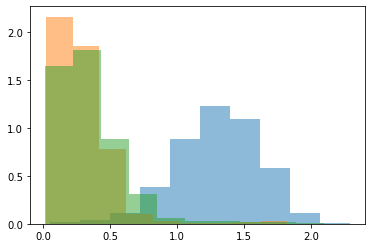

In [52]:
plt.hist(d12, density=True, alpha=0.5)
plt.hist(d1, density=True, alpha=0.5)
plt.hist(d2, density=True, alpha=0.5);

# GBM

In [54]:
d1 = []
for i in range(102):
    for j in range(i+1, 102):
        d1.append(np.sqrt(((t1_gbm[i]-t1_gbm[j])**2).sum()))

In [55]:
d2 = []
for i in range(102):
    for j in range(i+1, 102):
        d2.append(np.sqrt(((t2_gbm[i]-t2_gbm[j])**2).sum()))

In [56]:
d12 = []
for i in range(102):
    for j in range(102):
        d12.append(np.sqrt(((t1_gbm[i]-t2_gbm[j])**2).sum()))

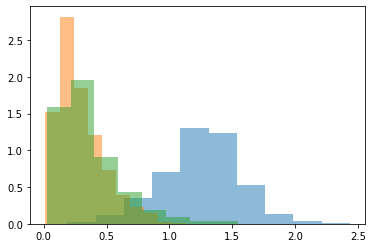

In [57]:
plt.hist(d12, density=True, alpha=0.5)
plt.hist(d1, density=True, alpha=0.5)
plt.hist(d2, density=True, alpha=0.5);

# GBM vs BGPD

In [67]:
d1 = []
for i in range(180):
    for j in range(102):
        d1.append(np.sqrt(((t1_bgpd[i]-t1_gbm[j])**2).sum()))

In [68]:
d2 = []
for i in range(180):
    for j in range(102):
        d2.append(np.sqrt(((t2_bgpd[i]-t2_gbm[j])**2).sum()))

In [69]:
d12 = []
for i in range(180):
    for j in range(102):
        d12.append(np.sqrt(((t1_bgpd[i]-t2_gbm[j])**2).sum()))

In [70]:
d21 = []
for i in range(102):
    for j in range(180):
        d21.append(np.sqrt(((t1_gbm[i]-t2_bgpd[j])**2).sum()))

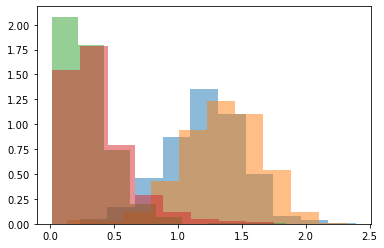

In [72]:
plt.hist(d12, density=True, alpha=0.5)
plt.hist(d21, density=True, alpha=0.5)

plt.hist(d1, density=True, alpha=0.5)
plt.hist(d2, density=True, alpha=0.5);

# GBM, distance between percentiles from distance between TR, TE

In [76]:
import pandas as pd

In [79]:
df_gbm = pd.read_csv('~/df_gbm_stats_mri.csv', index_col=0)

root = Path('/anvar/public_datasets/preproc_study/percentiles/gbm/4a_resamp')
patient_id = [folder.name for folder in root.glob('*')]

In [116]:
df_gbm['EchoTime_normed'] = (df_gbm['EchoTime'] - df_gbm['EchoTime'].mean()) / df_gbm['EchoTime'].std()
df_gbm['RepetitionTime_normed'] = (df_gbm['RepetitionTime'] - df_gbm['RepetitionTime'].mean()) / df_gbm['RepetitionTime'].std()
df_gbm['VoxelVolume_normed'] = (df_gbm['VoxelVolume'] - df_gbm['VoxelVolume'].mean()) / df_gbm['VoxelVolume'].std()

In [85]:
len(patient_id)

102

In [143]:
df_gbm_t1 = df_gbm.query('MR_sequence=="T1"')
df_gbm_t2 = df_gbm.query('MR_sequence=="T2"')

In [94]:
d_parameters = []
d_percentiles = []
for i in range(102):
    for j in range(i, 102):
        p1 = patient_id[i]
        p2 = patient_id[j]
        a = df_gbm_t1.query('PatientID==@p1')[['EchoTime_normed','RepetitionTime_normed']].values[0]
        b = df_gbm_t1.query('PatientID==@p2')[['EchoTime_normed','RepetitionTime_normed']].values[0]
        d_parameters.append(np.sqrt(((a-b)**2).sum()))
        d_percentiles.append(np.sqrt(((t1_gbm[i]-t1_gbm[j])**2).sum()))

In [102]:
df_gbm['MR_sequence'].unique()

array(['CT1', 'FLAIR', 'T1', 'T2'], dtype=object)

In [103]:
color = {
    'CT1':'blue',
    'FLAIR':'red',
    'T1':'black',
    'T2':'green'
}

In [ ]:
t1_gbm, t2_gbm, t1c_gbm, flair_gbm

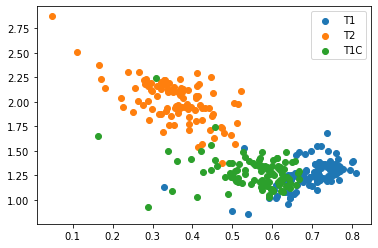

In [142]:
i = 3
j = 4
plt.scatter(t1_gbm[:, i], t1_gbm[:, j], label='T1')
plt.scatter(t2_gbm[:, i], t2_gbm[:, j], label='T2')
plt.scatter(flair_gbm[:, i], flair_gbm[:, j], label='T1C')
# plt.scatter(t1c_gbm[:, i], t1c_gbm[:, j])
plt.legend();
# plt.scatter(t1_gbm[2], t1_gbm[3])


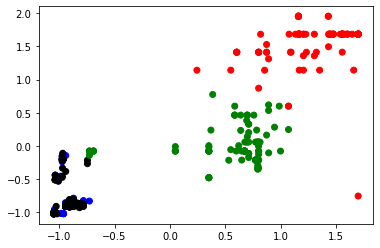

In [104]:
plt.scatter(df_gbm['EchoTime_normed'], df_gbm['RepetitionTime_normed'],color=df_gbm['MR_sequence'].map(color))

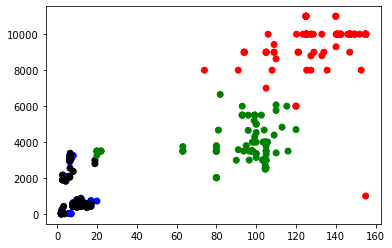

In [114]:
plt.scatter(df_gbm['EchoTime'], df_gbm['RepetitionTime'],color=df_gbm['MR_sequence'].map(color))

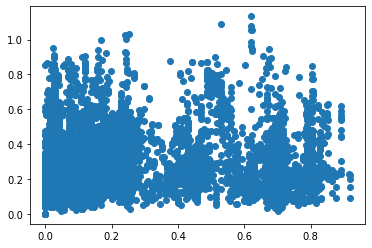

In [97]:
plt.scatter(d_parameters, d_percentiles)

In [148]:
d_parameters = []
d_percentiles = []
for i in range(102):
    for j in range(i+1, 102):
        p1 = patient_id[i]
        p2 = patient_id[j]
        a = df_gbm_t1.query('PatientID==@p1')[['EchoTime_normed','RepetitionTime_normed']].values[0]
        b = df_gbm_t2.query('PatientID==@p2')[['EchoTime_normed','RepetitionTime_normed']].values[0]
        d_parameters.append(np.sqrt(((a-b)**2).sum()))
        d_percentiles.append(np.sqrt(((t1_gbm[i]-t2_gbm[j])**2).sum()))

In [150]:
list(range(102,102))

[]

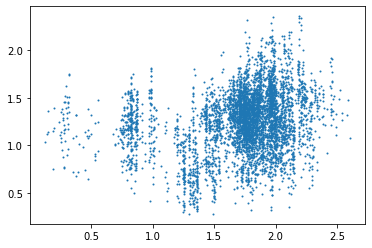

In [149]:
plt.scatter(d_parameters, d_percentiles, s=1)

In [151]:
from sklearn.metrics import r2_score

In [155]:
d_parameters = np.array(d_parameters)
d_percentiles = np.array(d_percentiles)

In [156]:
a = d_parameters[d_parameters>1]
b = d_percentiles[d_parameters>1]

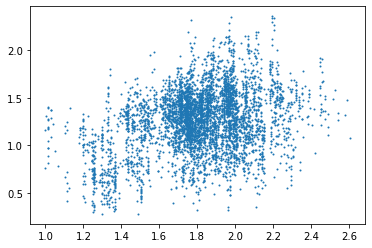

In [159]:
plt.scatter(a, b, s=1)

In [158]:
r2_score(a, b)

-5.95501604766101

In [90]:
102*101/2

5151.0

In [110]:
d_parameters = []
d_percentiles = []
for i in range(102):
    for j in range(i, 102):
        p1 = patient_id[i]
        p2 = patient_id[j]
        a = df_gbm_t1.query('PatientID==@p1')['RepetitionTime_normed'].values[0]
        b = df_gbm_t1.query('PatientID==@p2')['RepetitionTime_normed'].values[0]
        d_parameters.append(np.sqrt(((a-b)**2).sum()))
        d_percentiles.append(np.sqrt(((t1_gbm[i]-t1_gbm[j])**2).sum()))

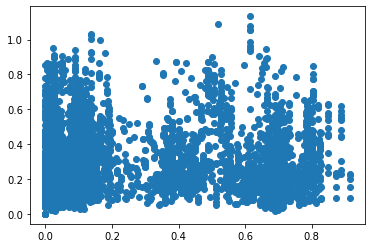

In [111]:
plt.scatter(d_parameters, d_percentiles)

In [112]:
d_parameters = []
d_percentiles = []
for i in range(102):
    for j in range(i, 102):
        p1 = patient_id[i]
        p2 = patient_id[j]
        a = df_gbm_t1.query('PatientID==@p1')[['EchoTime','RepetitionTime']].values[0]
        b = df_gbm_t1.query('PatientID==@p2')[['EchoTime','RepetitionTime']].values[0]
        d_parameters.append(np.sqrt(((a-b)**2).sum()))
        d_percentiles.append(np.sqrt(((t1_gbm[i]-t1_gbm[j])**2).sum()))

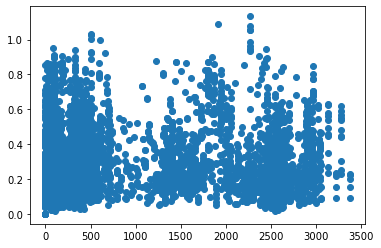

In [113]:
plt.scatter(d_parameters, d_percentiles)

In [118]:
d_parameters = []
d_percentiles = []
for i in range(102):
    for j in range(i, 102):
        p1 = patient_id[i]
        p2 = patient_id[j]
        a = df_gbm_t1.query('PatientID==@p1')[['EchoTime_normed','RepetitionTime_normed', 'VoxelVolume_normed']].values[0]
        b = df_gbm_t1.query('PatientID==@p2')[['EchoTime_normed','RepetitionTime_normed', 'VoxelVolume_normed']].values[0]
        d_parameters.append(np.sqrt(((a-b)**2).sum()))
        d_percentiles.append(np.sqrt(((t1_gbm[i]-t1_gbm[j])**2).sum()))

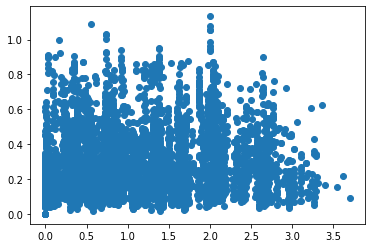

In [119]:
plt.scatter(d_parameters, d_percentiles)

In [120]:
d_parameters = []
d_percentiles = []
for i in range(102):
    for j in range(i, 102):
        p1 = patient_id[i]
        p2 = patient_id[j]
        a = df_gbm_t1.query('PatientID==@p1')[['EchoTime','RepetitionTime', 'VoxelVolume']].values[0]
        b = df_gbm_t1.query('PatientID==@p2')[['EchoTime','RepetitionTime', 'VoxelVolume']].values[0]
        d_parameters.append(np.sqrt(((a-b)**2).sum()))
        d_percentiles.append(np.sqrt(((t1_gbm[i]-t1_gbm[j])**2).sum()))

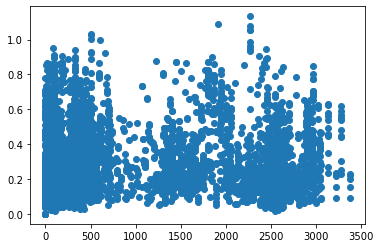

In [121]:
plt.scatter(d_parameters, d_percentiles)